# Xenograft analysis: Linear growth + snapshot TGI with Tukey (R)

This notebook loads `xenograft_volume.csv`, draws **linear-scale** growth curves (mean±SEM; spaghetti optional),
and computes **snapshot Tumor Growth Inhibition (TGI)** at Day 45 (or latest valid day) with **Tukey HSD all-vs-all** multiple comparisons.

AUC-based analyses are intentionally **omitted** per spec.

- Growth curves: combined + faceted panels + per-group
- Snapshot TGI lollipop (per mouse)
- Snapshot TGI box+swarm with **Tukey annotations (q < 0.01)**

In [1]:
# 0) Packages
req <- c('tidyverse','janitor','stringr','readr','scales',
         'lmerTest','ggbeeswarm','ggpubr','forcats','ragg','emmeans')
for (p in req) if (!requireNamespace(p, quietly = TRUE)) install.packages(p, repos='https://cloud.r-project.org')
invisible(lapply(req, library, character.only = TRUE))
theme_set(theme_minimal(base_size = 12))

Warning message:
“пакет ‘ggplot2’ был собран под R версии 4.3.3”
Warning message:
“пакет ‘tibble’ был собран под R версии 4.3.3”
Warning message:
“пакет ‘purrr’ был собран под R версии 4.3.3”
Warning message:
“пакет ‘lubridate’ был собран под R версии 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Присоединяю пакет: ‘janitor’


Следующие объекты скрыты от ‘package:stats’:

    chisq.test, fisher.test


Warning message:
“пакет ‘scales’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘scales’


Следующий объе

In [2]:
# 1) Config & helpers
SNAPSHOT_DAY <- 45
CTRL_FALLBACK <- 'Non-TD'
SHOW_SPAGHETTI <- FALSE  # set TRUE to show mouse-level trajectories
outdir <- 'figures'
if (!dir.exists(outdir)) dir.create(outdir)

pal_std <- c(
  'Intact'                     = '#F8766D',
  'Non-TD'                     = '#B79F00',
  'anti-HER2 Construct #1'     = '#00BA38',
  'anti-HER2 Construct #2'     = '#00BFC4',
  'anti-HER2 Construct #3'     = '#C77CFF'
)

save_jpeg <- function(plot, filename, width=9, height=6, dpi=600){
  ragg::agg_jpeg(filename = file.path(outdir, paste0(filename, '.jpeg')),
                 width = width, height = height, units = 'in', res = dpi)
  on.exit(dev.off(), add = TRUE)
  print(plot)
}

library(emmeans)
library(ggpubr)
library(dplyr)
library(tidyr)
library(stringr)
library(forcats)

In [3]:
# 2) Load & tidy data
raw <- readr::read_csv('xenograft_volume.csv', show_col_types = FALSE) |>
  janitor::clean_names()
stopifnot('sample' %in% names(raw))

dat_long <- raw |>
  mutate(sample = stringr::str_squish(sample)) |>
  pivot_longer(cols = -all_of('sample'), names_to = 'day_chr', values_to = 'volume') |>
  mutate(day = readr::parse_number(day_chr),
         volume = as.numeric(volume)) |>
  arrange(sample, day) |>
  filter(!is.na(day)) |>
  mutate(
    group = case_when(
      str_detect(sample, '^Anti-HER2/neu Construct #1') ~ 'anti-HER2 Construct #1',
      str_detect(sample, '^Anti-HER2/neu Construct #2') ~ 'anti-HER2 Construct #2',
      str_detect(sample, '^Anti-HER2/neu Construct #3') ~ 'anti-HER2 Construct #3',
      str_detect(sample, '^Non-TD') ~ 'Non-TD',
      str_detect(sample, '^Intact') ~ 'Intact',
      TRUE ~ 'Other'
    ),
    mouse_id = factor(sample)
  ) |>
  filter(group != 'Other') |>
  mutate(group = factor(group, levels = c('Intact','Non-TD','anti-HER2 Construct #1','anti-HER2 Construct #2','anti-HER2 Construct #3')))

dat_long |>
  summarise(n_mice = n_distinct(mouse_id), min_day=min(day), max_day=max(day), .by = group) |>
  print(n=Inf)

# A tibble: 5 × 4
  group                  n_mice min_day max_day
  <fct>                   <int>   <dbl>   <dbl>
1 anti-HER2 Construct #1      9       0      45
2 anti-HER2 Construct #2      9       0      45
3 anti-HER2 Construct #3      9       0      45
4 Intact                      9       0      45
5 Non-TD                      9       0      45


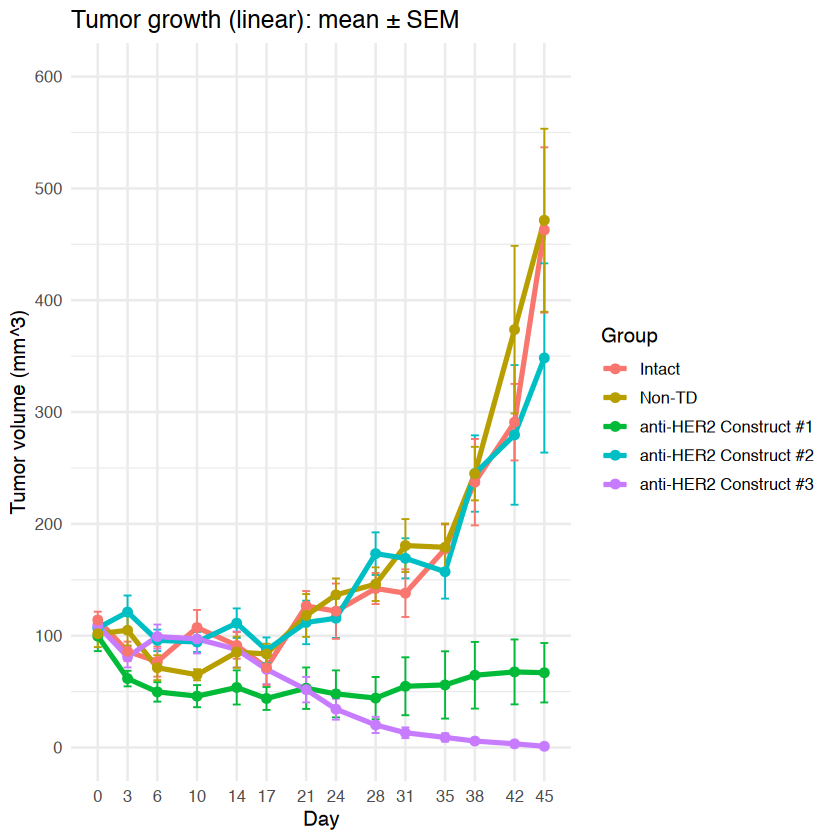

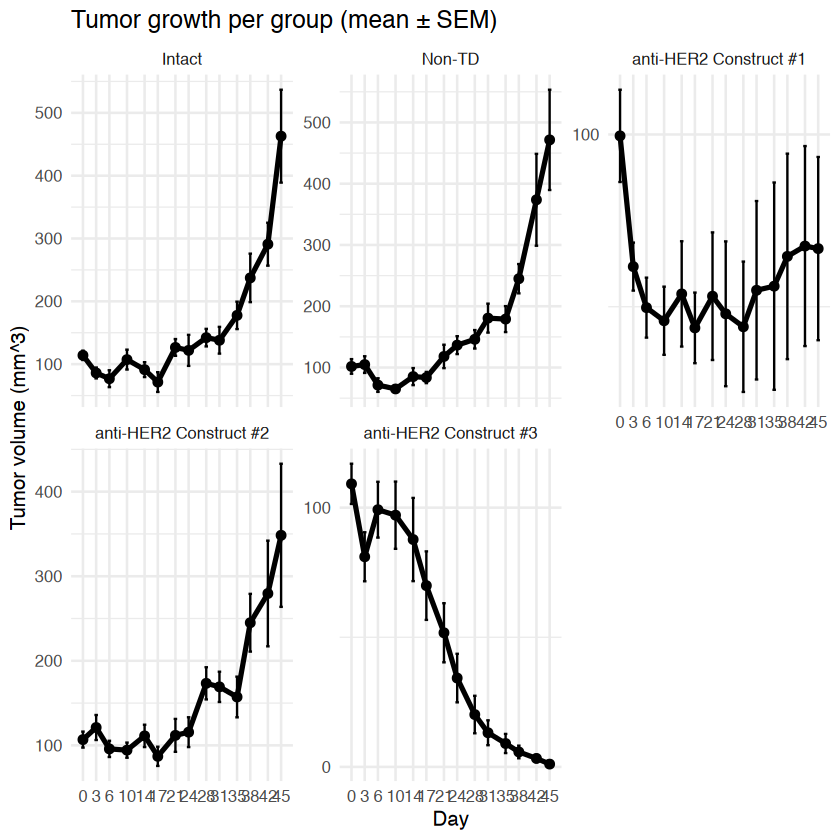

In [4]:
# 3) Linear-scale growth curves
day_breaks <- sort(unique(dat_long$day))
sum_lin <- dat_long |>
  summarise(n=dplyr::n(), mean=mean(volume, na.rm=TRUE), sd=sd(volume, na.rm=TRUE), sem=sd/sqrt(n), .by=c(group, day))
y_max_all <- max(sum_lin$mean + sum_lin$sem, na.rm = TRUE)
y_breaks_all <- seq(0, ceiling(y_max_all/100)*100, by = 100)

p_growth_combined <- ggplot()
if (SHOW_SPAGHETTI) {
  p_growth_combined <- p_growth_combined +
    geom_line(data = dat_long, aes(day, volume, group = mouse_id, color = group), alpha = 0.25, linewidth = 0.5)
}
p_growth_combined <- p_growth_combined +
  geom_line(data = sum_lin, aes(day, mean, color = group), linewidth = 1.1) +
  geom_errorbar(data = sum_lin, aes(day, ymin = pmax(mean - sem, 0), ymax = mean + sem, color = group), width = 0.8, linewidth = 0.4) +
  geom_point(data = sum_lin, aes(day, mean, color = group), size = 2) +
  scale_x_continuous(breaks = day_breaks) +
  scale_y_continuous(breaks = y_breaks_all, limits = c(0, max(y_breaks_all)), labels = scales::comma) +
  scale_color_manual(values = pal_std) +
  labs(x='Day', y='Tumor volume (mm^3)', color='Group', title='Tumor growth (linear): mean ± SEM') +
  theme(legend.position='right', panel.grid.minor.x = element_blank())
p_growth_combined
save_jpeg(p_growth_combined, '01_growth_linear_combined', width=12.5, height=7.5)

p_growth_panels <- ggplot(sum_lin, aes(day, mean)) +
  geom_line(color='black', linewidth=1.1) +
  geom_errorbar(aes(ymin=pmax(mean - sem, 0), ymax=mean + sem), width=0.8) +
  geom_point(size=2) +
  facet_wrap(~ group, scales='free_y') +
  scale_x_continuous(breaks = day_breaks) +
  scale_y_continuous(breaks = scales::breaks_width(100), labels = scales::comma) +
  labs(x='Day', y='Tumor volume (mm^3)', title='Tumor growth per group (mean ± SEM)') +
  theme(panel.grid.minor.x = element_blank())
p_growth_panels
save_jpeg(p_growth_panels, '02_growth_linear_panels', width=10, height=7)

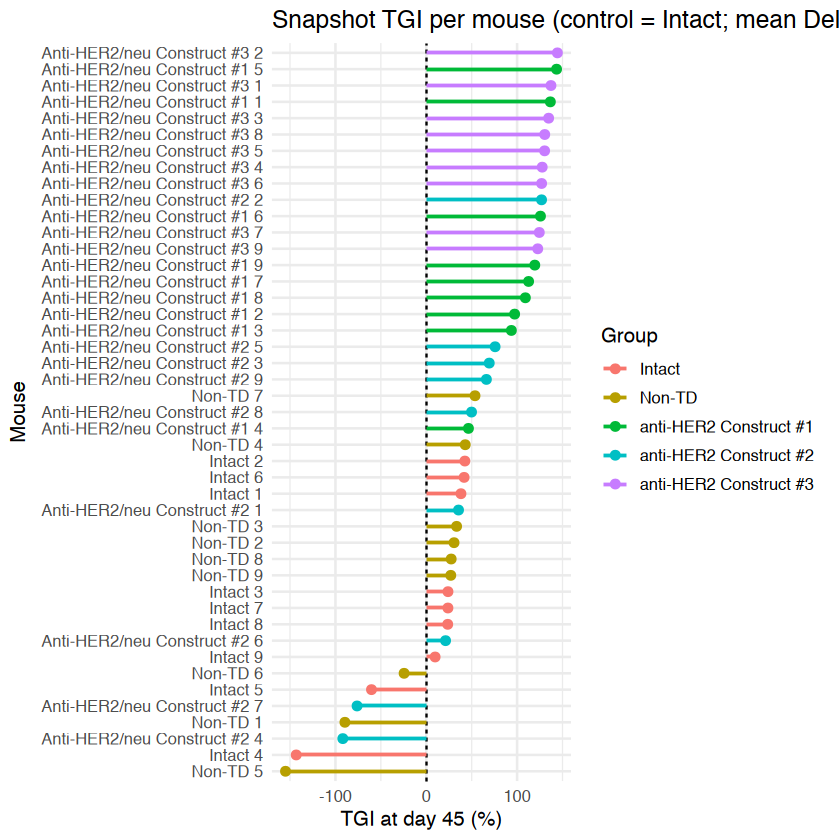

In [5]:
# 4) Snapshot TGI (non-AUC)
snap_wide <- dat_long |>
  filter(day %in% c(0, SNAPSHOT_DAY)) |>
  select(mouse_id, group, day, volume) |>
  tidyr::pivot_wider(names_from = day, values_from = volume, names_prefix = 'day_') |>
  tidyr::drop_na(day_0, !!sym(paste0('day_', SNAPSHOT_DAY))) |>
  mutate(delta = !!sym(paste0('day_', SNAPSHOT_DAY)) - day_0)

ctrl <- if ('Intact' %in% snap_wide$group) 'Intact' else CTRL_FALLBACK
delta_ctrl <- snap_wide |> filter(group == ctrl) |> summarise(mean_delta = mean(delta, na.rm=TRUE), .groups='drop') |> pull(mean_delta)

tgi_df <- snap_wide |>
  mutate(TGI = 100 * (1 - (delta / delta_ctrl))) |>
  mutate(group = factor(group, levels = levels(dat_long$group))) |>
  arrange(group, desc(TGI))

title_lol <- sprintf('Snapshot TGI per mouse (control = %s; mean Delta(control) = %.1f mm^3)', ctrl, delta_ctrl)
p_tgi_lol <- ggplot(tgi_df, aes(x = reorder(mouse_id, TGI), y = TGI, color = group)) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_segment(aes(xend = reorder(mouse_id, TGI), y = 0, yend = TGI), linewidth = 0.8) +
  geom_point(size = 2) +
  coord_flip() +
  scale_color_manual(values = pal_std) +
  labs(x='Mouse', y=sprintf('TGI at day %s (%%)', SNAPSHOT_DAY), title=title_lol, color='Group')
p_tgi_lol
save_jpeg(p_tgi_lol, '03_tgi_snapshot_lollipop', width=8, height=11)


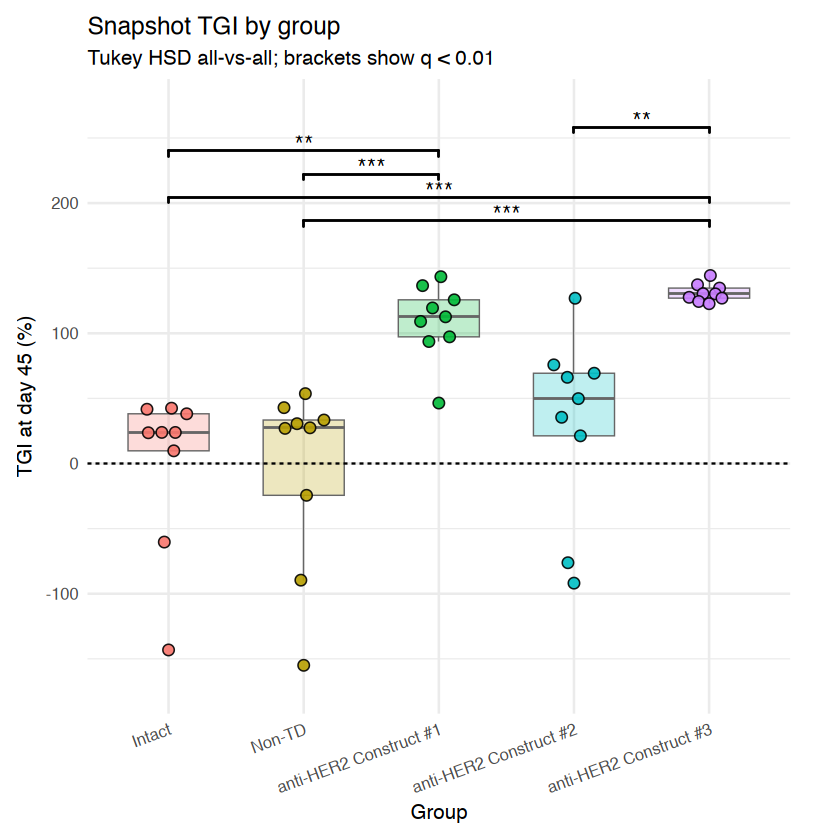

In [6]:
# 5) TGI box+swarm with Tukey

# Clean factor and drop NAs
tgi_df <- tgi_df %>%
  filter(!is.na(TGI)) %>%
  mutate(group = fct_drop(group))

# ANOVA + Tukey (all vs all)
m_tgi   <- lm(TGI ~ group, data = tgi_df)
emm_tgi <- emmeans(m_tgi, ~ group)
tuk_tbl <- as.data.frame(summary(pairs(emm_tgi, adjust = "tukey"))) %>%
  rename(q.value = p.value) %>%
  separate(contrast, c("group1","group2"), sep = " - ") %>%
  # strip parentheses from emmeans labels so they match factor levels
  mutate(
    group1 = str_replace_all(str_trim(group1), "^[()]+|[()]+$", ""),
    group2 = str_replace_all(str_trim(group2), "^[()]+|[()]+$", ""),
    stars  = case_when(
      q.value < 0.001 ~ "***",
      q.value < 0.01  ~ "**",
      q.value < 0.05  ~ "*",
      TRUE            ~ "ns"
    )
  )

# Keep only q < 0.01 and map to numeric x positions (prevents fake x labels)
lvl <- levels(tgi_df$group); pos <- setNames(seq_along(lvl), lvl)
ann_tbl <- tuk_tbl %>%
  filter(q.value < 0.01) %>%
  mutate(
    xmin_num = unname(pos[group1]),
    xmax_num = unname(pos[group2])
  ) %>%
  filter(!is.na(xmin_num), !is.na(xmax_num)) %>%
  arrange(q.value)

# Compute bracket heights, then axis limits (room for brackets)
rng   <- range(tgi_df$TGI, na.rm = TRUE)
span  <- if (diff(rng) == 0) 1 else diff(rng)
y0    <- max(tgi_df$TGI, na.rm = TRUE) + 0.08 * span
step  <- 0.06 * span
if (nrow(ann_tbl) > 0) {
  ann_tbl <- ann_tbl %>%
    mutate(y.position = y0 + step * row_number(), label = stars)
}
y_lower <- min(tgi_df$TGI, na.rm = TRUE) - 0.05 * span
y_upper <- max(c(tgi_df$TGI, if (nrow(ann_tbl) > 0) ann_tbl$y.position else NA),
               na.rm = TRUE) + 0.05 * span

# Plot
p_tgi_box <- ggplot(tgi_df, aes(group, TGI, fill = group)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.25, width = 0.6,
               color = "grey40", linewidth = 0.3) +
  ggbeeswarm::geom_quasirandom(aes(fill = group), width = 0.2, alpha = 0.9,
                               shape = 21, color = "black", size = 2.6) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  scale_fill_manual(values = pal_std, guide = "none") +
  scale_color_manual(values = pal_std, guide = "none") +
  scale_y_continuous(limits = c(y_lower, y_upper)) +
  coord_cartesian(clip = "off") +
  labs(x = "Group",
       y = sprintf("TGI at day %s (%%)", SNAPSHOT_DAY),
       title = "Snapshot TGI by group",
       subtitle = "Tukey HSD all-vs-all; brackets show q < 0.01") +
  theme(axis.text.x = element_text(angle = 20, hjust = 1),
        plot.margin = margin(10, 30, 10, 10))

if (nrow(ann_tbl) > 0) {
  p_tgi_box <- p_tgi_box +
    ggpubr::stat_pvalue_manual(
      ann_tbl,
      label = "label",
      xmin  = "xmin_num", xmax = "xmax_num",
      y.position = "y.position",
      tip.length = 0.01,
      bracket.size = 0.6,
      size = 5,
      inherit.aes = FALSE
    )
} else {
  message("No Tukey contrasts meet q < 0.01; plotting without brackets.")
}

p_tgi_box
save_jpeg(p_tgi_box, "04_tgi_snapshot_box_swarm_Tukey_q001", width = 9.5, height = 8)

In [7]:
# 6) Session info
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 15.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C/UTF-8/C/C/C/C

time zone: Asia/Yerevan
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] emmeans_1.11.1   ragg_1.2.7       ggpubr_0.6.0     ggbeeswarm_0.7.2
 [5] lmerTest_3.1-3   lme4_1.1-35.1    Matrix_1.6-4     scales_1.4.0    
 [9] janitor_2.2.0    lubridate_1.9.4  forcats_1.0.0    stringr_1.5.1   
[13] dplyr_1.1.4      purrr_1.0.4      readr_2.1.5      tidyr_1.3.1     
[17] tibble_3.3.0     ggplot2_3.5.2    tidyverse_2.0.0 

loaded via a namespace (and not attached):
 [1] tidyselect_1.2.1    IRdisplay_1.1       vipor_0.4.7        
 [4] farver_